In [35]:
path2numFive = "C:/Users/Alberto/OneDrive - Aarhus universitet/Skrivebord/github/data/dataFromNumberFive/20211213/baslerPulsatility/"
nameFile = "20211213_4.rls"
fileName = path2numFive + nameFile

In [36]:
import numpy as np
import struct
import warnings

In [45]:


with open(fileName, 'rb') as file:
    #file.readline(8)
    sizeX = struct.unpack('<Q', file.read(8))[0]
    sizeY = struct.unpack('<Q', file.read(8))[0]
    sizeT = struct.unpack('<Q', file.read(8))[0]
    #data = file.read(4)[0:16]
    print(sizeX)
    print(sizeY)
    print(sizeT)
    

512
1600
56760


In [48]:
import numpy as np
import struct
import warnings

def readRLS(fileName, *args):

    # Check if the fileName ends with .rls, add .rls otherwise
    if not fileName.endswith('.rls'):
        fileName += '.rls'

    # Initializing default values for optional and hidden parameters
    framesToSkip = 0
    framesToRead = None
    ROI = None
    dataSize = 1  # Initiate data size as default for 'uint8'

    # Checking that inputs are in the correct format
    for iVar, arg in enumerate(args, start=1):
        if iVar == 1:
            framesToSkip = arg
            if not (round(framesToSkip) == framesToSkip):
                framesToSkip = round(framesToSkip)
                warnings.warn('Rounding number of frames to nearest integer')
        elif iVar == 2 and arg:
            framesToRead = arg
            if not (round(framesToRead) == framesToRead):
                framesToRead = round(framesToRead)
                warnings.warn('Rounding number of frames to nearest integer')
        elif iVar == 3:
            ROI = arg
            if np.shape(ROI) != (2, 2):
                raise ValueError(
                    'ROI format is incorrect, please check that the matrix dimensions are:\n'
                    '[firstRow, lastRow;\n firstColumn, lastColumn]'
                )

    # Read the meta data
    with open(fileName, 'rb') as file:
        file.seek(0*1024)
        sizeX = struct.unpack('<Q', file.read(8))[0]
        sizeY = struct.unpack('<Q', file.read(8))[0]
        sizeT = struct.unpack('<Q', file.read(8))[0]
        sampling = struct.unpack('<Q', file.read(8))[0]
        version = file.read(4).decode()

        if version == 'Ver.':
            nVer = struct.unpack('<Q', file.read(8))[0]
            if nVer > 1:
                dataSize = struct.unpack('<Q', file.read(8))[0]

        # Correct default values based on meta data
        if ROI is None:
            ROI = [[1, sizeY], [1, sizeX]]
        if framesToRead is None:
            framesToRead = sizeT

        # Determine data type
        if dataSize == 1:
            dataType = 'uint8'
        elif dataSize == 2:
            dataType = 'uint16'
        else:
            raise ValueError('Unidentified data type')

        # Pre-allocate memory for arrays
        timeStamps = np.zeros(framesToRead, dtype=np.int64)
        data_shape = (ROI[0][1]-ROI[0][0]+1, ROI[1][1]-ROI[1][0]+1, framesToRead)
        data = np.zeros(data_shape, dtype=dataType)

        # Move to the first timeStamp/frame location
        firstByte = 30*1024 + sizeX*sizeY*np.uint64(framesToSkip)*dataSize + 8*np.uint64(framesToSkip)
        file.seek(int(firstByte))
        #file.read(firstByte)

        # Read data
        for t in range(framesToRead):
            timeStamps[t] = struct.unpack('<Q', file.read(8))[0]
            frame = np.frombuffer(file.read(sizeY*sizeX*dataSize), dtype=dataType).reshape(sizeY, sizeX)
            data[:, :, t] = frame[ROI[0][0]-1:ROI[0][1], ROI[1][0]-1:ROI[1][1]]

    return data, sampling, timeStamps, sizeT



In [49]:
data, sampling, timeStamps, sizeT = readRLS(fileName,0,500)

In [51]:
type(data)

numpy.ndarray

In [112]:
# optimized version

import numpy as np
import struct
import warnings

def readRLSopt(fileName, *args):

    # Check if the fileName ends with .rls, add .rls otherwise
    if not fileName.endswith('.rls'):
        fileName += '.rls'

    # Initializing default values for optional parameters
    framesToSkip = 0
    framesToRead = None
    ROI = None
    dataSize = 1  # 1 is default for 'uint8'

    # Checking that inputs are in the correct format
    for iVar, arg in enumerate(args, start=1):
        rounded_arg = round(arg)
        if iVar == 1 and framesToSkip != rounded_arg:
            framesToSkip = rounded_arg
            warnings.warn('Rounding number of frames to nearest integer')
        elif iVar == 2 and framesToRead != rounded_arg and arg:
            framesToRead = rounded_arg
            warnings.warn('Rounding number of frames to nearest integer')
        elif iVar == 3:
            ROI = arg
            if np.shape(ROI) != (2, 2):
                raise ValueError(
                    'ROI format is incorrect, please check the matrix dimensions are:\n'
                    '[firstRow, lastRow;\n firstColumn, lastColumn]'
                )

    # Read the meta data
    with open(fileName, 'rb') as file:
        file.seek(0*1024)
        sizeX, sizeY, sizeT, sampling = struct.unpack('<QQQQ', file.read(32))
        version = file.read(4).decode()

        if version == 'Ver.':
            nVer = struct.unpack('<Q', file.read(8))[0]
            if nVer > 1:
                dataSize, = struct.unpack('<Q', file.read(8))
        print(dataSize)
        # Set default values based on meta data
        if ROI is None:
            ROI = [[1, sizeX], [1, sizeY]]
        if framesToRead is None:
            framesToRead = sizeT

        # Determine data type
        dt_lookup = {1: 'uint8', 2: 'uint16'}
        dataType = dt_lookup.get(dataSize)
        if dataType is None:
            raise ValueError('Unidentified data type')

        # Pre-allocate memory for arrays
        timeStamps = np.zeros(framesToRead, dtype=np.int64)
        data_shape = (ROI[0][1] - ROI[0][0] + 1, ROI[1][1] - ROI[1][0] + 1, framesToRead)

        data = np.zeros(data_shape, dtype=dataType)

        # Move to the first timeStamp/frame location
        firstByte = 30*1024 + sizeX*sizeY*np.uint64(framesToSkip)*dataSize + 8*np.uint64(framesToSkip)
        file.seek(int(firstByte))

        # Define dtype and itemsize
        dtype = np.dtype(dataType)
        itemsize = dtype.itemsize

        # Read data
        for t in range(framesToRead):
            timeStamps[t], = struct.unpack('<Q', file.read(8))
            frame_data = np.frombuffer(file.read(sizeY*sizeX*itemsize), dtype=dtype)
            frame = frame_data.reshape(sizeX, sizeY, order='C')
            data[:, :, t] = frame[ROI[0][0]-1:ROI[0][1], ROI[1][0]-1:ROI[1][1]]
        

    return data, sampling, timeStamps, sizeT


C:\Users\Alberto\AppData\Local\Temp\ipykernel_21216\1634183524.py:27: UserWarning: Rounding number of frames to nearest integer
  warnings.warn('Rounding number of frames to nearest integer')


1
uint8
1


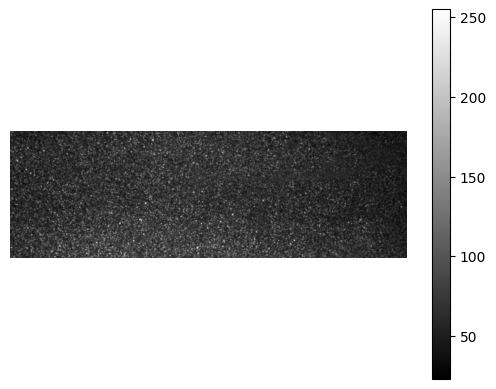

In [111]:
data, sampling, timeStamps, sizeT = readRLSopt(fileName,0,200)

frame_5 = get_frame(data, 10)
popup_frame(frame_5)

In [62]:
import time

start_time_normal = time.time()
data, sampling, timeStamps, sizeT = readRLS(fileName,0,500)
print("Normal version: --- %s seconds ---" % (time.time() - start_time_normal))

start_time_opt = time.time()
data, sampling, timeStamps, sizeT = readRLSopt(fileName,0,500)
print("Optimized version: --- %s seconds ---" % (time.time() - start_time_opt))

C:\Users\Alberto\AppData\Local\Temp\ipykernel_21216\161373910.py:27: UserWarning: Rounding number of frames to nearest integer
  warnings.warn('Rounding number of frames to nearest integer')


Normal version: --- 4.304024934768677 seconds ---
Optimized version: --- 4.232677936553955 seconds ---


In [72]:
def get_frame(data, frame_number):
    """
    Extracts a specified frame from the 3D ndarray data.

    Parameters:
        data (ndarray): The 3D data array from which to extract the frame.
        frame_number (int): The index of the frame to extract.

    Returns:
        ndarray: The extracted 2D frame.
    """
    if frame_number >= data.shape[2] or frame_number < 0:
        raise ValueError("Invalid frame number. It should be between 0 and {}.".format(data.shape[2]-1))
    return data[:,:,frame_number]


In [69]:
import matplotlib.pyplot as plt

def popup_frame(frame):
    """
    Pops up an interactive window displaying a 2D ndarray frame.

    Parameters:
        frame (ndarray): The 2D data frame to display.
    """
    plt.figure()
    plt.imshow(frame, cmap='gray')  # You can change the colormap if needed.
    plt.colorbar()
    plt.axis('off')  # to turn off axis numbers and ticks
    plt.show(block=True)  # block=True ensures the window stays open



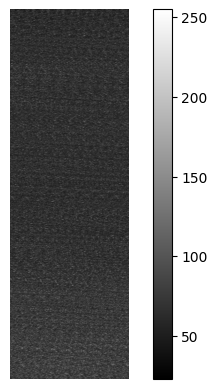

In [89]:
# Assuming you have already extracted the frame using the get_frame function
#data, sampling, timeStamps, sizeT = readRLSopt(fileName,0,500)

frame_5 = get_frame(data, 10)
popup_frame(frame_5)